# Notebook for analysing Volumetric and Pipette Data

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import seawater as sw
import scipy.stats as sci_st
from scipy.interpolate import interp1d
import numpy as np
import copy
sns.set(style="whitegrid") # I like this
mpl.rc('font', family='serif') # Cast serif as the font
mpl.rc('figure', figsize=[8, 5]) # Set fig size to something more fitting for A4 word doc

## Assessing different volumetric flask brands

In [2]:
vol_brands_df = pd.read_csv(r"S:\Marine Technology and Equipment\Hydrochemistry\Hydrochemistry Current\Flasks\Volumetric Data\brand_test.csv")
vol_sizes_df = pd.read_csv(r"S:\Marine Technology and Equipment\Hydrochemistry\Hydrochemistry Current\Flasks\size_test_data.csv")

In [3]:
vol_brands_df.head()

,Size,Brand,Flask,Replicate,Volume20,DryWeight
0,200,Glassco,1,a,200.054,83.8242
1,200,Glassco,1,b,200.081,83.8225
2,200,Glassco,1,c,200.030,83.8189
3,200,Glassco,2,a,200.102,89.6993
4,200,Glassco,2,b,200.050,89.6986


### The different brands:

In [4]:
set(vol_brands_df['Brand'])

{'Emil', 'Fortuna', 'Glassco', 'Simex'}

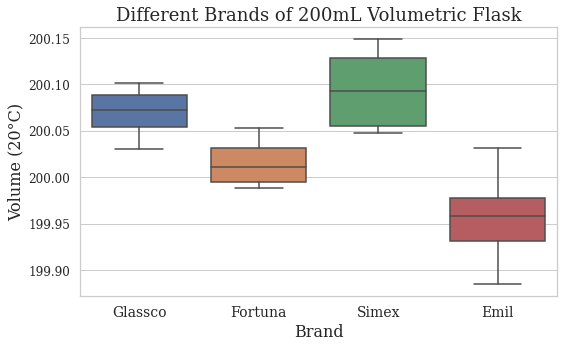

In [19]:
sns.boxplot(vol_brands_df['Brand'], vol_brands_df['Volume20'])

plt.xlabel("Brand", fontsize=16)
plt.ylabel("Volume (20°C)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.title('Different Brands of 200mL Volumetric Flask', fontsize=18)

plt.tight_layout()

plt.savefig('independent_iodate_standards.svg', format='svg')

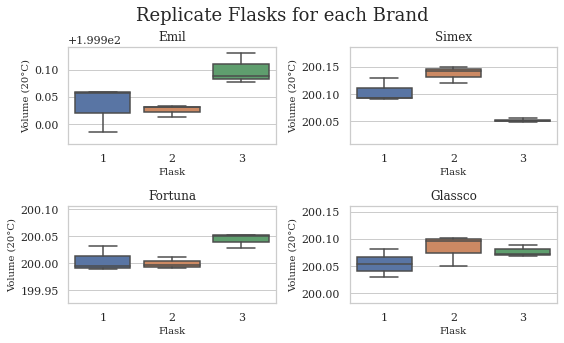

In [20]:
brands = set(vol_brands_df['Brand'])
fig = plt.figure(figsize=([8,5]))

plt.suptitle('Replicate Flasks for each Brand', fontsize=18)   

for i, brand in enumerate(brands):
    ax = fig.add_subplot(2,2,i+1)
    
    brand_subset = vol_brands_df.loc[vol_brands_df['Brand'] == brand] 
    
    sns.boxplot(brand_subset['Flask'], brand_subset['Volume20'], ax=ax)
    
    ax.set_title(brand)
    ax.set_ylabel('Volume (20°C)', fontsize=10)
    ax.set_xlabel('Flask', fontsize=10)
    
    mean = brand_subset['Volume20'].mean()

    lower_y = mean - 0.09
    upper_y = mean + 0.09
    
    ax.set_ylim(lower_y, upper_y)


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('replicate_flasks_each_brand.svg', format='svg')

## Assessing different volumetric sizes

In [7]:
vol_sizes_df.head()

,RH,Pressure,Temp,Size,Brand,Replicate,Volume20
0,32,102.278,20.1,50,Emil,1,50.0229
1,35,101.971,19.7,50,Emil,2,50.0215
2,30,102.970,19.8,50,Emil,3,50.0344
3,29,100.295,19.5,50,Emil,4,50.0115
4,33,101.086,19.9,50,Emil,5,50.0290


#### Plot the absolute spread of the different sizes, gauge error as flask size increases

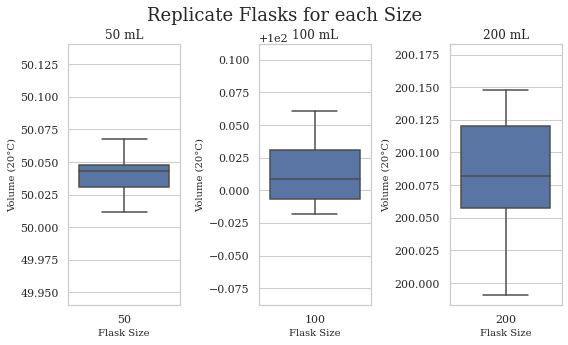

In [8]:
sizes = sorted(list(set(vol_sizes_df['Size'])))

fig = plt.figure(figsize=([8,5]))

plt.suptitle('Replicate Flasks for each Size', fontsize=18)   

for i, size in enumerate(sizes):
    ax = fig.add_subplot(1,3,i+1)
    
    size_subset = vol_sizes_df.loc[vol_sizes_df['Size'] == size] 
    
    sns.boxplot(size_subset['Size'], size_subset['Volume20'], ax=ax)
    
    ax.set_title(f'{size} mL')
    ax.set_ylabel('Volume (20°C)', fontsize=10)
    ax.set_xlabel('Flask Size', fontsize=10)
    
    mean = size_subset['Volume20'].mean()

    lower_y = mean - 0.1
    upper_y = mean + 0.1
    
    ax.set_ylim(lower_y, upper_y)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('replicate_flasks_each_size.svg', format='svg')

## Calculate the standard deviations of measurements within each size flask

In [9]:
calcd_sizes_sds_df = vol_sizes_df.groupby(['Size', 'Brand']).std().reset_index()

#### Calculate the relative standard deviation

In [10]:
calcd_sizes_sds_df['VolRSD'] = calcd_sizes_sds_df['Volume20']/calcd_sizes_sds_df['Size']

#### Compute the oneway F test  using absolute standard deviations of flasks

In [11]:
sci_st.f_oneway(calcd_sizes_sds_df['Volume20'].loc[calcd_sizes_sds_df['Size'] == 50],
                calcd_sizes_sds_df['Volume20'].loc[calcd_sizes_sds_df['Size'] == 100],
               calcd_sizes_sds_df['Volume20'].loc[calcd_sizes_sds_df['Size'] == 200])

F_onewayResult(statistic=1.7766098408174689, pvalue=0.24774474828085283)

#### Using relative standard deviations 

In [12]:
sci_st.f_oneway(calcd_sizes_sds_df['VolRSD'].loc[calcd_sizes_sds_df['Size'] == 50],
                calcd_sizes_sds_df['VolRSD'].loc[calcd_sizes_sds_df['Size'] == 100],
               calcd_sizes_sds_df['VolRSD'].loc[calcd_sizes_sds_df['Size'] == 200])

F_onewayResult(statistic=0.43850248944629755, pvalue=0.6641340314355557)

### Lets visualise the RSD for each flask 

In [13]:
conv_dict = {50: 1, 100: 2, 200: 3}
calcd_sizes_sds_df

sizes = sorted(list(set(calcd_sizes_sds_df['Size'])))
inds = []
for i, row in enumerate(calcd_sizes_sds_df.iterrows()):
    row = row[1]
    inds.append(conv_dict[row['Size']])
    
calcd_sizes_sds_df['ind'] = inds

In [14]:
calcd_sizes_sds_df

,Size,Brand,RH,Pressure,Temp,Replicate,Volume20,VolRSD,ind
0,50,Brand,2.387467,0.922346,0.164317,1.581139,0.013688,0.000274,1
1,50,Emil,2.387467,1.045161,0.223607,1.581139,0.008614,0.000172,1
2,50,Simax2,2.738613,1.045161,0.054772,1.581139,0.002855,0.000057,1
3,100,Brand,2.738613,1.045161,0.054772,1.581139,0.012367,0.000124,2
4,100,Emil,2.302173,1.045161,0.151658,1.581139,0.007538,0.000075,2
5,100,Emil Old,2.302173,1.045161,0.178885,1.581139,0.012756,0.000128,2
6,200,Glassco a,2.121320,1.045161,0.164317,1.581139,0.043913,0.000220,3
7,200,Glassco b,2.049390,1.045161,0.216795,1.581139,0.011452,0.000057,3
8,200,Pyrex,1.870829,1.045161,0.192354,1.581139,0.016026,0.000080,3


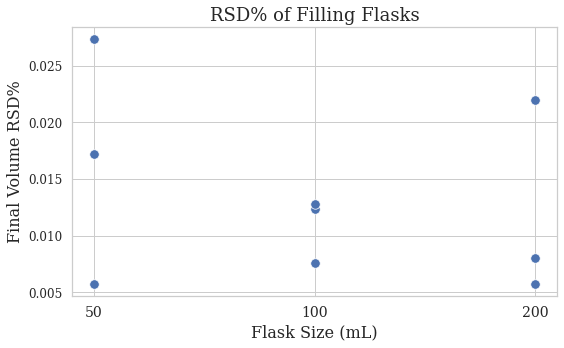

In [21]:
sns.scatterplot(calcd_sizes_sds_df['ind'], calcd_sizes_sds_df['VolRSD']*100, s=90)

plt.title('RSD% of Filling Flasks', fontsize=18)
plt.xlabel('Flask Size (mL)', fontsize=16)
plt.gca().set_xticks([1, 2, 3])
plt.gca().set_xticklabels([50, 100, 200])
plt.ylabel("Final Volume RSD%", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

#plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.tight_layout()
plt.savefig('rsd_flask_sizes.svg', format='svg')

## Assessing the different operators for Volumetrics

In [22]:
operator_vols = pd.read_csv(r"S:\Marine Technology and Equipment\Hydrochemistry\Hydrochemistry Current\Flasks\OperatorFlaskFilling.csv")

In [23]:
operator_vols.head()

,Size,Operator,Volume
0,50,Julie,49.990403
1,50,Julie,49.988999
2,50,Julie,49.988898
3,50,Julie,50.003444
4,50,Julie,49.988898


In [24]:
operator_vols.groupby(by=['Operator', 'Size']).describe()

Volume                                                \
               count        mean       std         min         25%   
Operator Size                                                        
Cassie   50     10.0   49.951501  0.013993   49.930154   49.939860   
         100    10.0   99.972540  0.016625   99.944763   99.964926   
         200     9.0  200.114034  0.014254  200.091786  200.106432   
Jack     50     10.0   50.023296  0.009219   50.001628   50.021390   
         100    10.0   99.997970  0.019841   99.942476   99.999154   
         200    10.0  200.154907  0.009242  200.137954  200.149641   
Julie    50     10.0   49.984695  0.024081   49.929011   49.976710   
         100    10.0   99.988049  0.014753   99.958867   99.981889   
         200    10.0  200.151818  0.048037  200.020015  200.153458   
Kendall  50     10.0   50.020467  0.019564   49.990955   50.006804   
         100    10.0   99.983545  0.019745   99.951805   99.973573   
         200    10.0  200.136740  0.037982  200.093244  200.112805   
Merinda  50     10.0   49.935581  0.013131   49.912800   49.928399   
         100    10.0   99.939778  0.026271   99.900896   99.920156   
         200    10.0  200.056790  0.022511  200.021158  200.036657   

                                                   
                      50%         75%         max  
Operator Size                                      
Cassie   50     49.951321   49.962932   49.970079  
         100    99.975710   99.986494   99.989604  
         200   200.110144  200.120677  200.134721  
Jack     50     50.024700   50.029189   50.034230  
         100   100.005223  100.006627  100.009185  
         200   200.155810  200.158493  200.170657  
Julie    50     49.988948   49.996873   50.017287  
         100    99.991971   99.995883  100.005614  
         200   200.164116  200.166348  200.187941  
Kendall  50     50.019996   50.027845   50.057764  
         100    99.987066   99.997699  100.010690  
         200   200.125395  200.161633  200.214424  
Merinda  50     49.937979   49.946631   49.950117  
         100    99.944633   99.957573   99.977837  
         200   200.059880  200.077435  200.083353

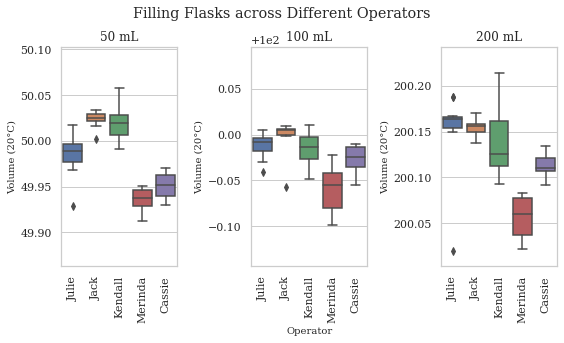

In [25]:
fig = plt.figure(figsize=([8,5]))

fig.suptitle('Filling Flasks across Different Operators')

for i, size in enumerate(sorted(list(set(operator_vols['Size'])))):
    ax = fig.add_subplot(1,3,i+1)
    size_subset = operator_vols.loc[operator_vols['Size'] == size]
    sns.boxplot(size_subset['Operator'], size_subset['Volume'], ax=ax)
    
    subset_mean = size_subset['Volume'].mean()
    
    lower_y = subset_mean - 0.12
    upper_y = subset_mean + 0.12
    
    ax.set_ylim(lower_y, upper_y)
    
    ax.set_title(f'{size} mL')
    ax.set_ylabel('Volume (20°C)', fontsize=10)
    if i == 1:
        ax.set_xlabel('Operator', fontsize=10)
    else:
        ax.set_xlabel('', fontsize=10)

    plt.xticks(rotation=90)
    
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('flask_fill_different_operators.svg', format='svg')

In [26]:
# Calculate the standard deviation of each flask for each operator, convert to RSD%
operator_vols_std = operator_vols.groupby(by=['Operator', 'Size']).std().reset_index()
operator_vols_std['rsd'] = operator_vols_std['Volume'] / operator_vols_std['Size'] * 100

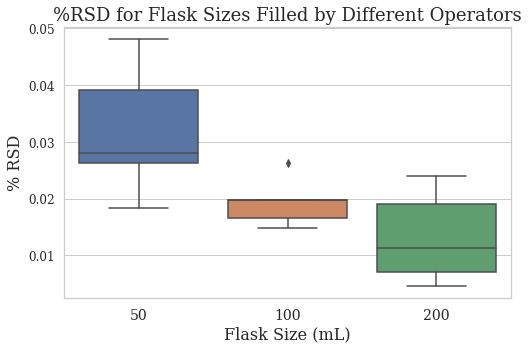

In [27]:
sns.boxplot(operator_vols_std['Size'], operator_vols_std['rsd'])
plt.title('%RSD for Flask Sizes Filled by Different Operators', fontsize=18)
plt.xlabel("Flask Size (mL)", fontsize=16)
plt.ylabel("% RSD", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)


fig.tight_layout()
plt.savefig('flask_fill_rsd_diff_operators.svg', format='svg')

In [28]:
operator_vols_rsd_medians = operator_vols_std.groupby(by=['Size']).median().reset_index()

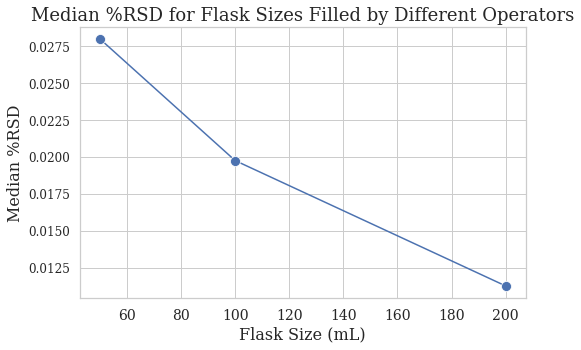

In [29]:
sns.lineplot(operator_vols_rsd_medians['Size'], operator_vols_rsd_medians['rsd'], marker='o', ms=10)

plt.title('Median %RSD for Flask Sizes Filled by Different Operators', fontsize=18)
plt.xlabel("Flask Size (mL)", fontsize=16)
plt.ylabel("Median %RSD", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

fig.tight_layout()
plt.savefig('flask_fill_median_rsd_diff_operators.svg', format='svg')

---

# Pipette data

In [30]:
pipette_tips = pd.read_csv(r"S:\Marine Technology and Equipment\Hydrochemistry\Hydrochemistry Current\Flasks\pipette_tips.csv")

In [31]:
pipette_tips.head()

,Pipette,Tip,Replicate,NomVol,Volume
0,Orange,1,1,97,0.0936
1,Orange,1,2,97,0.0950
2,Orange,1,3,97,0.0946
3,Orange,1,4,97,0.0951
4,Orange,1,5,97,0.0946


### Lets first look at the tip wetting data

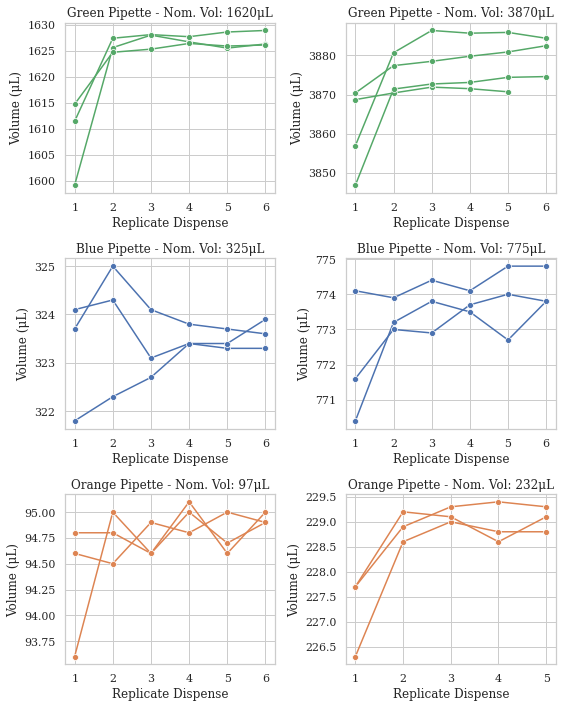

In [32]:
colour_converter = {'Green': '#55a868', 'Blue': '#4c72b0', 'Orange': '#dd8452'}
fig = plt.figure(figsize=([8,10]))

for i, colour in enumerate(['Green', 'Blue', 'Orange']):
    colour_subset = pipette_tips.loc[pipette_tips['Pipette'] == colour]
    
    #ax = fig.add_subplot(3,2,i+1)
    
    for j, nominal in enumerate(sorted(list(set(colour_subset['NomVol'])))):
        
        ax = fig.add_subplot(3,2,(((i+1)*2)-1)+j)
        
        nominal_subset = colour_subset.loc[colour_subset['NomVol'] == nominal]
        
        for tip in sorted(list(set(nominal_subset['Tip']))):
        
            tip_subset = nominal_subset.loc[nominal_subset['Tip'] == tip]
        
            sns.lineplot(tip_subset['Replicate'], tip_subset['Volume']*1000, ax=ax, color=colour_converter[colour], marker='o')
        
    
            ax.set_title(f'{colour} Pipette - Nom. Vol: {nominal}μL')
            ax.set_xlabel('Replicate Dispense')
            ax.set_ylabel('Volume (μL)')

fig.tight_layout()
plt.savefig('pipette_tip_replicates.svg', format='svg')

In [33]:
pipette_volumes = pd.read_csv(r"S:\Marine Technology and Equipment\Hydrochemistry\Hydrochemistry Current\Flasks\pipette_volumes.csv")
pipette_volumes['VolumeMicro'] = pipette_volumes['Volume'] * 1000

In [34]:
pipette_volumes.head()

,Pipette,Replicate,NomVol,Volume,VolumeMicro
0,Orange,1,30,0.0296,29.6
1,Orange,2,30,0.0297,29.7
2,Orange,3,30,0.0300,30.0
3,Orange,4,30,0.0297,29.7
4,Orange,5,30,0.0296,29.6


In [35]:
blue = pipette_volumes.loc[pipette_volumes['Pipette'] == 'Blue']

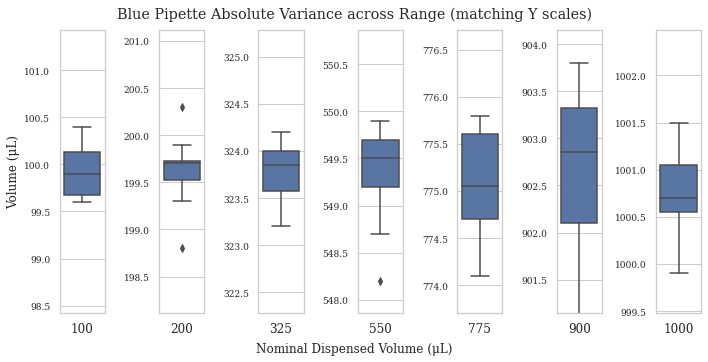

In [36]:
fig = plt.figure(figsize=([10,5]))

fig.suptitle('Blue Pipette Absolute Variance across Range (matching Y scales)')

for i, volume in enumerate(sorted(list(set(blue['NomVol'])))):
    ax = fig.add_subplot(1,len(set(blue['NomVol'])),i+1)
    volume_subset = blue.loc[blue['NomVol'] == volume]
    
    sns.boxplot(volume_subset['NomVol'], volume_subset['VolumeMicro'], ax=ax)
    
    subset_mean = volume_subset['VolumeMicro'].mean()
    
    lower_y = subset_mean - 1.5
    upper_y = subset_mean + 1.5
    
    ax.set_ylim(lower_y, upper_y)
    if i > 0:
        ax.set_ylabel('')
        ax.set_xlabel('')
    if i == 0:
        ax.set_ylabel('Volume (μL)')
        ax.set_xlabel('')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=9)
    
fig.text(0.5, 0.02, 'Nominal Dispensed Volume (μL)', ha='center')
    
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('blue_pipette_range.svg', format='svg')

In [37]:
green = pipette_volumes.loc[pipette_volumes['Pipette'] == 'Green']

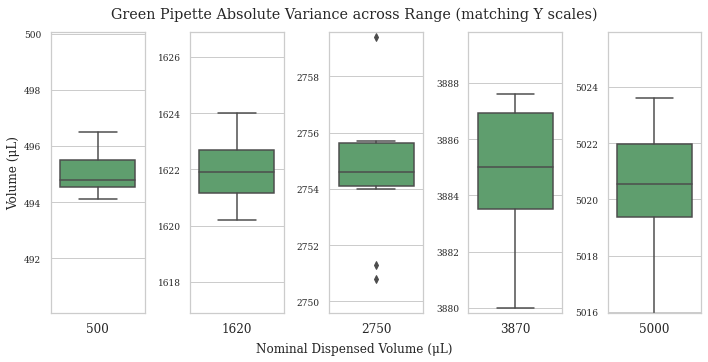

In [38]:
fig = plt.figure(figsize=([10,5]))

fig.suptitle('Green Pipette Absolute Variance across Range (matching Y scales)')

for i, volume in enumerate(sorted(list(set(green['NomVol'])))):
    ax = fig.add_subplot(1,len(set(green['NomVol'])),i+1)
    volume_subset = green.loc[green['NomVol'] == volume]
    
    sns.boxplot(volume_subset['NomVol'], volume_subset['VolumeMicro'], ax=ax, color='#55a868')
    
    subset_mean = volume_subset['VolumeMicro'].mean()
    
    lower_y = subset_mean - 5
    upper_y = subset_mean + 5
    
    ax.set_ylim(lower_y, upper_y)
    if i > 0:
        ax.set_ylabel('')
        ax.set_xlabel('')
    if i == 0:
        ax.set_ylabel('Volume (μL)')
        ax.set_xlabel('')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=9)
    
fig.text(0.5, 0.02, 'Nominal Dispensed Volume (μL)', ha='center')
    
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('green_pipette_range.svg', format='svg')

In [39]:
orange = pipette_volumes.loc[pipette_volumes['Pipette'] == 'Orange']

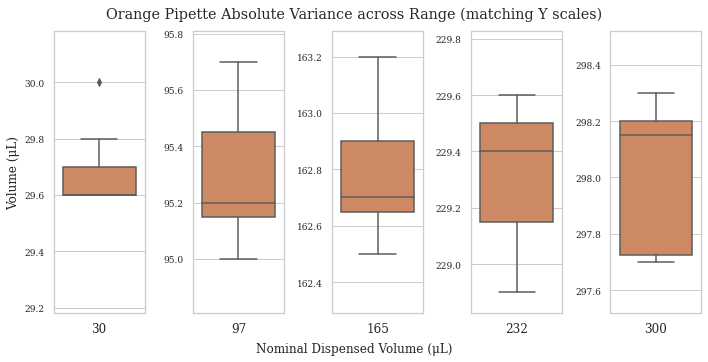

In [40]:
fig = plt.figure(figsize=([10,5]))

fig.suptitle('Orange Pipette Absolute Variance across Range (matching Y scales)')

for i, volume in enumerate(sorted(list(set(orange['NomVol'])))):
    ax = fig.add_subplot(1,len(set(orange['NomVol'])),i+1)
    volume_subset = orange.loc[orange['NomVol'] == volume]
    
    sns.boxplot(volume_subset['NomVol'], volume_subset['VolumeMicro'], ax=ax, color='#dd8452')
    
    subset_mean = volume_subset['VolumeMicro'].mean()
    
    lower_y = subset_mean - 0.5
    upper_y = subset_mean + 0.5
    
    ax.set_ylim(lower_y, upper_y)
    if i > 0:
        ax.set_ylabel('')
        ax.set_xlabel('')
    if i == 0:
        ax.set_ylabel('Volume (μL)')
        ax.set_xlabel('')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=9)
    
fig.text(0.5, 0.02, 'Nominal Dispensed Volume (μL)', ha='center')
    
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('orange_pipette_range.svg', format='svg')

In [41]:
pipette_rsd = pipette_volumes.groupby(by=['Pipette', 'NomVol']).std().reset_index()
pipette_rsd['RSD'] = pipette_rsd['VolumeMicro']/pipette_rsd['NomVol']*100

In [42]:
pipette_rsd.to_csv('pipette_rsd.csv')

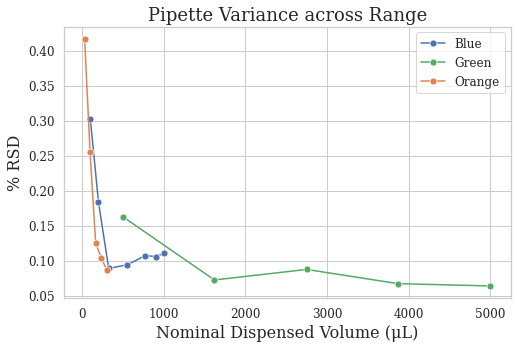

In [43]:
for colour in sorted(list(set(pipette_rsd['Pipette']))):
    colour_subset = pipette_rsd.loc[pipette_rsd['Pipette'] == colour]
    
    sns.lineplot(colour_subset['NomVol'], colour_subset['RSD'], color=colour_converter[colour], marker='o', lw=1.5, ms=7, label=colour)

plt.xlabel('Nominal Dispensed Volume (μL)', fontsize=16)
plt.ylabel('% RSD', fontsize=16)
plt.title('Pipette Variance across Range', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)


fig.tight_layout()
plt.savefig('pipette_rsd_over_range.svg', format='svg')

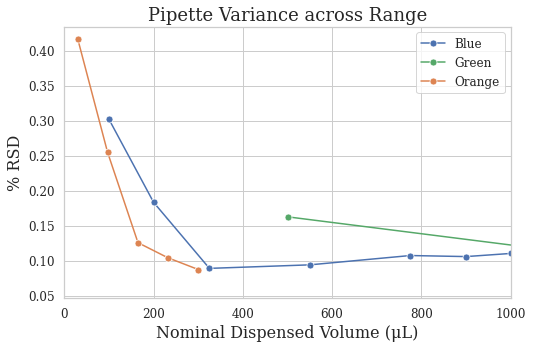

In [44]:
for colour in sorted(list(set(pipette_rsd['Pipette']))):
    colour_subset = pipette_rsd.loc[pipette_rsd['Pipette'] == colour]
    
    sns.lineplot(colour_subset['NomVol'], colour_subset['RSD'], color=colour_converter[colour], marker='o', lw=1.5, ms=7, label=colour)

plt.xlabel('Nominal Dispensed Volume (μL)', fontsize=16)
plt.ylabel('% RSD', fontsize=16)
plt.title('Pipette Variance across Range', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)


plt.xlim(0, 1000)

fig.tight_layout()
plt.savefig('pipette_rsd_over_range_zoomed.svg', format='svg')

---

# Monte Carlo Simulations

### Defining the Pipette error functions

These have just been visually created using the plotting functions in Excel

In [45]:
pipette_volume_means = pipette_volumes.groupby(by=['Pipette', 'NomVol']).mean().reset_index()

In [46]:
blue_error_interp = interp1d(pipette_rsd['NomVol'].loc[pipette_rsd['Pipette'] == 'Blue'], 
              pipette_rsd['VolumeMicro'].loc[pipette_rsd['Pipette'] == 'Blue'], 
              kind='linear')
def blue_error_function(volume):
    return blue_error_interp(volume)

In [47]:
blue_vol_interp = interp1d(pipette_volume_means['NomVol'].loc[pipette_volume_means['Pipette'] == 'Blue'], 
              pipette_volume_means['VolumeMicro'].loc[pipette_volume_means['Pipette'] == 'Blue'], 
              kind='linear')
def blue_vol_function(volume):
    return blue_vol_interp(volume)

In [48]:
green_error_interp = interp1d(pipette_rsd['NomVol'].loc[pipette_rsd['Pipette'] == 'Green'], 
              pipette_rsd['VolumeMicro'].loc[pipette_rsd['Pipette'] == 'Green'], 
              kind='linear')
def green_error_function(volume):
    return green_error_interp(volume)

In [49]:
green_vol_interp = interp1d(pipette_volume_means['NomVol'].loc[pipette_volume_means['Pipette'] == 'Green'], 
              pipette_volume_means['VolumeMicro'].loc[pipette_volume_means['Pipette'] == 'Green'], 
              kind='linear')
def green_vol_function(volume):
    return green_vol_interp(volume)

In [50]:
orange_error_interp = interp1d(pipette_rsd['NomVol'].loc[pipette_rsd['Pipette'] == 'Orange'], 
              pipette_rsd['VolumeMicro'].loc[pipette_rsd['Pipette'] == 'Orange'], 
              kind='linear')
def orange_error_function(volume):
    return orange_error_interp(volume)

In [51]:
orange_vol_interp = interp1d(pipette_volume_means['NomVol'].loc[pipette_volume_means['Pipette'] == 'Orange'], 
              pipette_volume_means['VolumeMicro'].loc[pipette_volume_means['Pipette'] == 'Orange'], 
              kind='linear')
def orange_vol_function(volume):
    return orange_vol_interp(volume)

In [52]:
volumetric_operator_filling = {
    'Cassie': {
        50: {
            'Mean': 49.9515,
            'Std': 0.01399
        },
        100: {
            'Mean': 99.9725,
            'Std': 0.01662,
        },
        200: {
            'Mean': 200.1140,
            'Std': 0.01425
        }
    },
    'Jack': {
        50: {
            'Mean': 50.023,
            'Std': 0.00921
        },
        100: {
            'Mean': 99.997,
            'Std': 0.0198
        },
        200: {
            'Mean': 200.154,
            'Std': 0.00924
        }
    },
    'Julie': {
        50: {
            'Mean': 49.9846,
            'Std': 0.02408
        },
        100: {
            'Mean': 99.9880,
            'Std': 0.01475
        },
        200: {
            'Mean': 200.1518,
            'Std': 0.0480
        }
    },
    'Kendall': {
        50: {
            'Mean': 50.020,
            'Std': 0.01956
        },
        100: {
            'Mean': 99.9835,
            'Std': 0.01974
        },
        200: {
            'Mean': 200.1367,
            'Std': 0.03798
        }
    },
    'Merinda': {
        50: {
            'Mean': 49.935,
            'Std': 0.01313
        },
        100: {
            'Mean': 99.9397,
            'Std': 0.026271
        },
        200: {
            'Mean': 200.0567,
            'Std': 0.02251
        }
    }
}

In [53]:
stock_concentrations = {
    'NOx':14000,
    'Phosphate':12000,
    'Silicate':14000,
    'Nitrite':14000,
    'Ammonia':10000
}

intermediates = {
    'Intermediate A': {
        'Size': 100,
        'Phosphate': {
            'DispVolume': 10000
        },
        'Ammonia': {
            'DispVolume': 8000
        }
    },
    'Intermediate B': {
        'Size': 100,
        'Nitrite': {
            'DispVolume': 2000
        }
    }
}

calibrants = {
    'cal_1': {
        'Size': 200,
        'NOx': {
            'Using': 'Stock',
            'DispVolume': 100,
        },
        'Phosphate': {
            'Using': 'Intermediate A',
            'DispVolume': 100
        },
        'Silicate': {
            'Using': 'Stock',
            'DispVolume': 100
        },
        'Nitrite': {
            'Using': 'Intermediate B',
            'DispVolume': 100
        },
        'Ammonia': {
            'Using': 'Intermediate A',
            'DispVolume': 100
        }
    },
    'cal_2': {
        'Size': 200,
        'NOx': {
            'Using': 'Stock',
            'DispVolume': 200,
        },
        'Phosphate': {
            'Using': 'Intermediate A',
            'DispVolume': 200
        },
        'Silicate': {
            'Using': 'Stock',
            'DispVolume': 200
        },
        'Nitrite': {
            'Using': 'Intermediate B',
            'DispVolume': 200
        },
        'Ammonia': {
            'Using': 'Intermediate A',
            'DispVolume': 200
        }
    },
    'cal_3': {
        'Size': 200,
        'NOx': {
            'Using': 'Stock',
            'DispVolume': 300,
        },
        'Phosphate': {
            'Using': 'Intermediate A',
            'DispVolume': 300
        },
        'Silicate': {
            'Using': 'Stock',
            'DispVolume': 400
        },
        'Nitrite': {
            'Using': 'Intermediate B',
            'DispVolume': 300
        },
        'Ammonia': {
            'Using': 'Intermediate A',
            'DispVolume': 300
        }
    },
    'cal_4': {
        'Size': 200,
        'NOx': {
            'Using': 'Stock',
            'DispVolume': 300,
        },
        'Phosphate': {
            'Using': 'Intermediate A',
            'DispVolume': 400
        },
        'Silicate': {
            'Using': 'Stock',
            'DispVolume': 800
        },
        'Nitrite': {
            'Using': 'Intermediate B',
            'DispVolume': 500
        },
        'Ammonia': {
            'Using': 'Intermediate A',
            'DispVolume': 400
        }
    },
    'cal_5': {
        'Size': 200,
        'NOx': {
            'Using': 'Stock',
            'DispVolume': 500,
        },
        'Phosphate': {
            'Using': 'Intermediate A',
            'DispVolume': 500
        },
        'Silicate': {
            'Using': 'Stock',
            'DispVolume': 1600
        },
        'Nitrite': {
            'Using': 'Intermediate B',
            'DispVolume': 1000
        },
        'Ammonia': {
            'Using': 'Intermediate A',
            'DispVolume': 500
        }
    }
}

In [70]:
operator = 'Kendall'

made_calibrants = {}

nuts = ['NOx', 'Phosphate', 'Silicate', 'Nitrite', 'Ammonia']
intermediate_converter = {'Phosphate': 'Intermediate A', 'Ammonia': 'Intermediate A', 'Nitrite': 'Intermediate B'}

array = []

for it in range(30):
    #print(it)
    for nut in nuts:
        #print(nut)
        if nut == 'Phosphate' or nut == 'Ammonia' or nut == 'Nitrite':

            intermediate_in_use = intermediate_converter[nut]

            original_volume = intermediates[intermediate_in_use][nut]['DispVolume']
            if original_volume > 5000:
                volume = original_volume / 2
            else:
                volume = original_volume

            actual_volume = green_vol_function(volume)        
            volume_error = green_error_function(volume)

            randomised_pipette_volume = np.random.normal(actual_volume, volume_error, 1)[0]
            #print(randomised_pipette_volume)
            # Need to dispense twice if volume greater than 5000uL
            if original_volume > 5000:
                randomised_pipette_volume = randomised_pipette_volume + np.random.normal(actual_volume, volume_error, 1)[0]


            # Need to calculate the error of the Intermediate Volumetric

            randomised_intermediate_cal_volume = np.random.normal(volumetric_operator_filling[operator][intermediates[intermediate_in_use]['Size']]['Mean'],
                                                                    volumetric_operator_filling[operator][intermediates[intermediate_in_use]['Size']]['Std'], 1)[0]

            intermediates[intermediate_in_use][nut]['Concentration'] = (stock_concentrations[nut] * randomised_pipette_volume/1000) / randomised_intermediate_cal_volume
            intermediates[intermediate_in_use][nut]['NominalConcentration'] = (stock_concentrations[nut] * original_volume/1000) / intermediates[intermediate_in_use]['Size']


        for cal in calibrants.keys():
            #print(cal)

            # Get Volumetric size of calibrant
            cal_volume = calibrants[cal]['Size']
            #print(f'Cal volume: {cal_volume}')


            # Determine random pipette volume

            if calibrants[cal][nut]['DispVolume'] < 100:
                actual_volume = orange_vol_function(calibrants[cal][nut]['DispVolume'])
                volume_error = orange_error_function(calibrants[cal][nut]['DispVolume'])

            elif calibrants[cal][nut]['DispVolume'] >= 100 and calibrants[cal][nut]['DispVolume'] <= 1000:
                actual_volume = blue_vol_function(calibrants[cal][nut]['DispVolume'])
                volume_error = blue_error_function(calibrants[cal][nut]['DispVolume'])

            else:
                actual_volume = green_vol_function(calibrants[cal][nut]['DispVolume'])
                volume_error = green_error_function(calibrants[cal][nut]['DispVolume'])

            # Calculate the randomised pipette volume
            randomised_pipette_volume = np.random.normal(actual_volume, volume_error, 1)[0]
            #print(f'Random pipette volume: {randomised_pipette_volume}')


            # Get the random volumetric flask fill volume dependent on the operator
            randomised_cal_volume = np.random.normal(volumetric_operator_filling[operator][calibrants[cal]['Size']]['Mean'],
                                                    volumetric_operator_filling[operator][calibrants[cal]['Size']]['Std'], 1)[0]

            if calibrants[cal][nut]['Using'] == 'Stock':
                stock_concentration = stock_concentrations[nut]

                cal_concentration = (stock_concentration * randomised_pipette_volume / 1000) / randomised_cal_volume
                nom_cal_concentration = (stock_concentration * calibrants[cal][nut]['DispVolume'] / 1000) / calibrants[cal]['Size']


            else:
                # Get what intermediate is being used
                intermediate_concentration = intermediates[calibrants[cal][nut]['Using']][nut]['Concentration']

                cal_concentration = (intermediate_concentration * randomised_pipette_volume / 1000) / randomised_cal_volume
                nom_cal_concentration = (intermediates[calibrants[cal][nut]['Using']][nut]['NominalConcentration'] * calibrants[cal][nut]['DispVolume'] / 1000) / calibrants[cal]['Size']

            calibrants[cal][nut]['Concentration'] = cal_concentration
            calibrants[cal][nut]['NominalConcentration'] = nom_cal_concentration

            #print(f'The randomised calibrant concentration: {cal_concentration}')

    made_calibrants[it] = copy.deepcopy(calibrants)

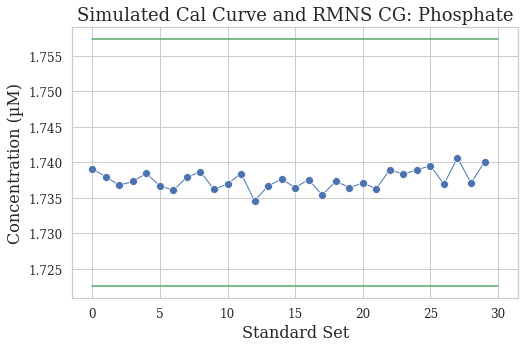

In [76]:
nut_of_int = 'Phosphate'

# RMNS to check, first number is cert. value, second is standard dev

rmns_val = 1.74
rmns_sd = 0.000

upper_one = rmns_val + (rmns_val * 0.01) 
lower_one = rmns_val - (rmns_val * 0.01)

#upper_one = rmns_val + 0.02
#lower_one = rmns_val - 0.02

for r in range(1):
    rmns_values = []

    for x in made_calibrants:
        it = made_calibrants[x]

        concs = []
        nom_concs = []
        for cal in it:
            concs.append(it[cal][nut_of_int]['Concentration'])
            nom_concs.append(it[cal][nut_of_int]['NominalConcentration'])

        cal_coefs = np.polyfit(concs, nom_concs, 1)
        cal_eqtn= np.poly1d(cal_coefs)

        rmns_value = np.random.normal(rmns_val, rmns_sd, 1)[0]

        fitted_rmns_value = cal_eqtn(rmns_value)

        rmns_values.append(fitted_rmns_value)
        
    sns.lineplot(range(len(rmns_values)), rmns_values, lw=1, ms=8, marker='o')
    
    sns.lineplot([0, 30], [upper_one, upper_one], color='#55a868')
    sns.lineplot([0, 30], [lower_one, lower_one], color='#55a868')

plt.title('Simulated Cal Curve and RMNS CG: Phosphate', fontsize=18)
plt.xlabel('Standard Set', fontsize=16)
plt.ylabel('Concentration (µM)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('simulated_rmns_phosphate_CG_kendall.svg', format='svg')

In [485]:
colour_converter = {'Green': '#55a868', 'Blue': '#4c72b0', 'Orange': '#dd8452'}

In [378]:
operator_vols.groupby(by=['Operator', 'Size']).describe().reset_index()

Operator Size Volume                                                \
                  count        mean       std         min         25%   
0    Cassie   50   10.0   49.951501  0.013993   49.930154   49.939860   
1    Cassie  100   10.0   99.972540  0.016625   99.944763   99.964926   
2    Cassie  200    9.0  200.114034  0.014254  200.091786  200.106432   
3      Jack   50   10.0   50.023296  0.009219   50.001628   50.021390   
4      Jack  100   10.0   99.997970  0.019841   99.942476   99.999154   
5      Jack  200   10.0  200.154907  0.009242  200.137954  200.149641   
6     Julie   50   10.0   49.984695  0.024081   49.929011   49.976710   
7     Julie  100   10.0   99.988049  0.014753   99.958867   99.981889   
8     Julie  200   10.0  200.151818  0.048037  200.020015  200.153458   
9   Kendall   50   10.0   50.020467  0.019564   49.990955   50.006804   
10  Kendall  100   10.0   99.983545  0.019745   99.951805   99.973573   
11  Kendall  200   10.0  200.136740  0.037982  200.093244  200.112805   
12  Merinda   50   10.0   49.935581  0.013131   49.912800   49.928399   
13  Merinda  100   10.0   99.939778  0.026271   99.900896   99.920156   
14  Merinda  200   10.0  200.056790  0.022511  200.021158  200.036657   

                                        
           50%         75%         max  
0    49.951321   49.962932   49.970079  
1    99.975710   99.986494   99.989604  
2   200.110144  200.120677  200.134721  
3    50.024700   50.029189   50.034230  
4   100.005223  100.006627  100.009185  
5   200.155810  200.158493  200.170657  
6    49.988948   49.996873   50.017287  
7    99.991971   99.995883  100.005614  
8   200.164116  200.166348  200.187941  
9    50.019996   50.027845   50.057764  
10   99.987066   99.997699  100.010690  
11  200.125395  200.161633  200.214424  
12   49.937979   49.946631   49.950117  
13   99.944633   99.957573   99.977837  
14  200.059880  200.077435  200.083353